# (not done) Node Classification with Graph Neural Networks
> 공부

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [GNN]

ref: https://keras.io/examples/graph/gnn_citations/

- GNN의 간단한 구현 예제
- 그래프 컨볼루션 레이어 구현

사용한 cora dataset

https://relational.fit.cvut.cz/dataset/CORA

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-05-25 13:59:13.457128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-25 13:59:13.457158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 데이터 정의

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [3]:
data_dir

'/home/csy/.keras/datasets/cora'

In [4]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [5]:
citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  5429 non-null   int64
 1   source  5429 non-null   int64
dtypes: int64(2)
memory usage: 85.0 KB


The target column includes the paper ids cited by the paper ids in the source column.

In [6]:
citations.sample(frac=1).head()

,target,source
2296,20601,20602
3687,78511,575402
4442,189623,683355
2616,28350,341188
2178,18811,1112686


In [7]:
citations

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [8]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [9]:
papers

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


dataset.saple(n): 데이터에서 랜덤으로 n개를 뽑는다.

In [10]:
papers.sample(5)

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
136,8703,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
824,77826,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based
2015,32260,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
131,1136310,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
2047,61312,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms


In [11]:
print(papers.sample(5).T)

                            1108             673              1773  \
paper_id                 1103031          1104191            78508   
term_0                         0                0                0   
term_1                         0                0                1   
term_2                         0                0                0   
term_3                         0                0                0   
...                          ...              ...              ...   
term_1429                      0                0                0   
term_1430                      0                0                0   
term_1431                      0                0                0   
term_1432                      0                0                0   
subject    Probabilistic_Methods  Neural_Networks  Neural_Networks   

                      1365             1091  
paper_id             90655          1128425  
term_0                   0                0  
term_1               

the count of the papers in each subject.

In [12]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [13]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [14]:
papers

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,2370,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2704,2371,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2705,2372,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2706,955,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---

In [15]:
papers["subject"].unique()

array([2, 5, 4, 3, 6, 1, 0])

데이터 셋 내의 유일한 값을 찾고 싶을 때 사용하는 `unique()` 고유한 값이 출력된다.

---

In [16]:
# example of enumerate() 열반복 시행
df = pd.DataFrame([[10,6,7,8],
                   [1,9,12,14],
                   [5,8,10,6]],
                  columns = ['a','b','c','d'])

for (index, colname) in enumerate(df):
    print(index, df[colname].values)

0 [10  1  5]
1 [6 9 8]
2 [ 7 12 10]
3 [ 8 14  6]


---

In [17]:
class_values

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [18]:
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [19]:
paper_idx

{35: 0,
 40: 1,
 114: 2,
 117: 3,
 128: 4,
 130: 5,
 164: 6,
 288: 7,
 424: 8,
 434: 9,
 463: 10,
 504: 11,
 506: 12,
 887: 13,
 906: 14,
 910: 15,
 936: 16,
 940: 17,
 941: 18,
 943: 19,
 1026: 20,
 1033: 21,
 1034: 22,
 1035: 23,
 1213: 24,
 1237: 25,
 1246: 26,
 1272: 27,
 1365: 28,
 1385: 29,
 1481: 30,
 1688: 31,
 1694: 32,
 1717: 33,
 1786: 34,
 1817: 35,
 1919: 36,
 1949: 37,
 1951: 38,
 1952: 39,
 1953: 40,
 1955: 41,
 1956: 42,
 1959: 43,
 1997: 44,
 1999: 45,
 2354: 46,
 2440: 47,
 2653: 48,
 2654: 49,
 2658: 50,
 2663: 51,
 2665: 52,
 2695: 53,
 2696: 54,
 2698: 55,
 2702: 56,
 3084: 57,
 3085: 58,
 3095: 59,
 3097: 60,
 3101: 61,
 3112: 62,
 3187: 63,
 3191: 64,
 3192: 65,
 3217: 66,
 3218: 67,
 3220: 68,
 3222: 69,
 3223: 70,
 3229: 71,
 3231: 72,
 3232: 73,
 3233: 74,
 3235: 75,
 3236: 76,
 3237: 77,
 3240: 78,
 3243: 79,
 3828: 80,
 3932: 81,
 4274: 82,
 4329: 83,
 4330: 84,
 4335: 85,
 4553: 86,
 4584: 87,
 4637: 88,
 4649: 89,
 4660: 90,
 4804: 91,
 4878: 92,
 4983: 93

`isin`메서드는 DataFrame객체의 각 요소가 values값과 일치하는지 여부를 bool형식으로 반환합니다.

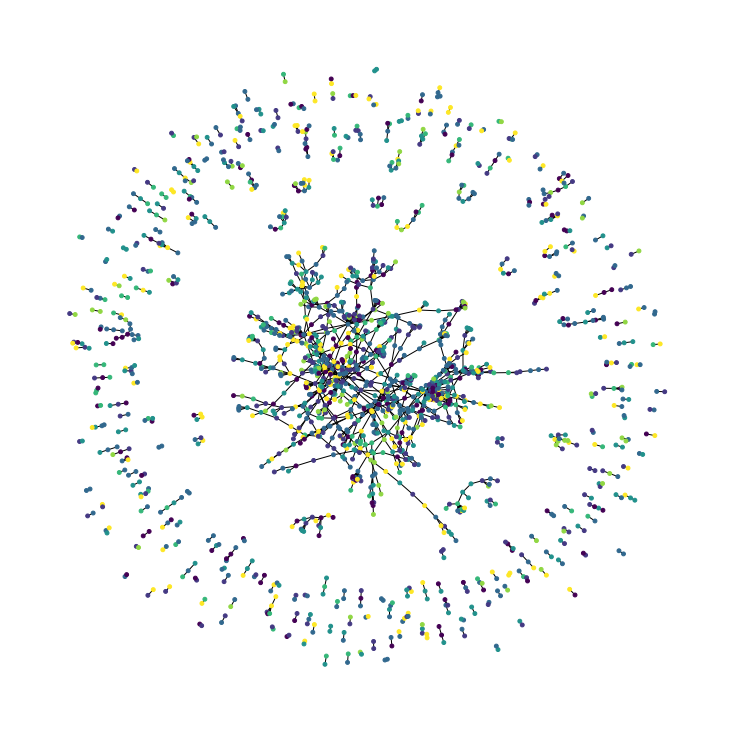

In [20]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Split the dataset into stratified train and test sets
- 데이터를 계츤화된 체스트와 train셋으로 나누기

DataFrame으로 부터 특정 비율의 표본을 무작위로 추출하기 (fraction) `df.sample(frac=0.5)`
- DataFrame으로 부터 특정 비율(fraction)으로 무작위 표본 추출을 하고 싶으면 frac 매개변수에 0~1 사이의 부동소수형(float) 값을 입력

In [21]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1324, 1435)
Test data shape: (1384, 1435)


### Implement Train and Evaluate Experiment
- train 으로 시험해서 test 평가

In [22]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

This function compiles and trains an input model using the given training data.
- 주어진 training data로 입력 모델 컴파일 및 train하는 함수

- Adam 사용
- 학습률은 0.01
- 손실함수(`losses.SparseCategoricalCrossentropy()`) (https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
    - Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers. If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss. There should be # classes floating point values per feature for y_pred and a single floating point value per feature for y_true.
    - 두 개 이상의 레이블 클래스가 있는 경우 이 crossentropy loss function을 사용한다. 레이블은 정수로 제공될 것으로 기대힌다. one-hot representation을 사용하여 레이블을 나타내려면 CategoricalCrossentropy loss를 사용한다. # classes에 대한 기능당 부동 소수점 값 y_pred 과 y_true에 대한 기능당 단일 부동 소수점 값이 있어야 한다.
    - `from_logits`
        - Whether y_pred is expected to be a logits tensor. By default, we assume that y_pred encodes a probability distribution.
        - y_pred가 logits tensor로 예상되는지의 여부다. 기본설정은 y_pred가 확률분포라고 (from_logit=False) 되어 있다.
    - Both, categorical cross entropy and sparse categorical cross entropy have the same loss function which you have mentioned above. The only difference is the format in which you mention $Y_i$ (i,e true labels).(https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other)
        - If your $Y_i$'s are one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): $[1,0,0] , [0,1,0], [0,0,1]$
        - But if your $Y_i$'s are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: $[1] , [2], [3]$
- metric(`tf.keras.metrics.SparseCategoricalAccuracy()`)
    - tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None)
        - name $\to$ (Optional) string name of the metric instance.

- callback(`keras.callbacks.EarlyStopping()`) (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) (Stop training when a monitored metric has stopped improving. 모니터된 metric이 improve를 멈출때 훈련이 중지된다.)
    - tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=0,verbose=0,mode='auto',baseline=None,restore_best_weights=False)
        - monitor	Quantity to be monitored.
        - patience	Number of epochs with no improvement after which training will be stopped.
        - restore_best_weights	Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set.
            - 가중치를 재복원할 것인지의 여부를 뭍는다. False라면 훈련의 마지막 단예에서 얻은 모델 가중치를 얻게 된다. 기저치와 관련있어서 baseline에서 에폭 변화가 없으면 그 상태에서 best 에폭으로부터 가중치를 재복원하는 것 같은..

In [23]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

This function displays the loss and accuracy curves of the model during training.
- 훈련하는 동안 손실과 정확도 곡선을 나타내는 함수

In [24]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

### Implement Feedforward Network (FFN) Module
- 순방향 신경망 구현

- 활성화함수(`tf.nn.gelu`) (https://www.tensorflow.org/api_docs/python/tf/nn/gelu) (Gaussian Error Linear Unit (GELU) activation function.)
    - tf.nn.gelu(features, approximate=False, name=None)
    - Gaussian error linear unit (GELU) computes $x * P(X <= x)$, where $P(X) \sim N(0, 1)$. The (GELU) nonlinearity weights inputs by their value, rather than gates inputs by their sign as in ReLU.
        - GELU 가우시안 에러 선형 단위(?), Relu 함수는 부호에 따라 입력함수를 처리해주었다면, Gelu 함수는 값에 따라 입력함수를 처리한다. x $\times$ (x의 확률이 표준정규분포를 따를때 x 보다 작을 확률(?))

In [25]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

### Build a Baseline Neural Network Model

In [26]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

Implement a baseline classifier
- We add five FFN blocks with skip connections, so that we generate a baseline model with roughly the same number of parameters as the GNN models to be built later.
- skip connection을 가진 FFN 블록을 5개 추가해서 나중에 GNN 모델 만들때 파라미터의 수를 대략적으로 기준 모델과 같게 하도록 한다.

---

이게 뭘까..

In [58]:
f"ffn_block1"

'ffn_block1'

앞에 f붙이면 문자열로 인식 https://docs.python.org/3/reference/lexical_analysis.html#f-strings

---

위에서 hidden_units은 [32,32]로, num_class는 class index 수로 정의

In [27]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [28]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 2s 79ms/step - loss: 3.7616 - acc: 0.1458 - val_loss: 1.8445 - val_acc: 0.2965
Epoch 2/300
5/5 [==============================] - 0s 23ms/step - loss: 2.8579 - acc: 0.2489 - val_loss: 1.8428 - val_acc: 0.3015
Epoch 3/300
5/5 [==============================] - 0s 23ms/step - loss: 2.3271 - acc: 0.2427 - val_loss: 1.8394 - val_acc: 0.3166
Epoch 4/300
5/5 [==============================] - 0s 26ms/step - loss: 2.1560 - acc: 0.2471 - val_loss: 1.8297 - val_acc: 0.3367
Epoch 5/300
5/5 [==============================] - 0s 27ms/step - loss: 2.0094 - acc: 0.2827 - val_loss: 1.8160 - val_acc: 0.3417
Epoch 6/300
5/5 [==============================] - 0s 28ms/step - loss: 1.9495 - acc: 0.3084 - val_loss: 1.7959 - val_acc: 0.3769
Epoch 7/300
5/5 [==============================] - 0s 28ms/step - loss: 1.7797 - acc: 0.3609 - val_loss: 1.7727 - val_acc: 0.4020
Epoch 8/300
5/5 [==============================] - 0s 29ms/step - loss: 1.6973 - acc: 0.37

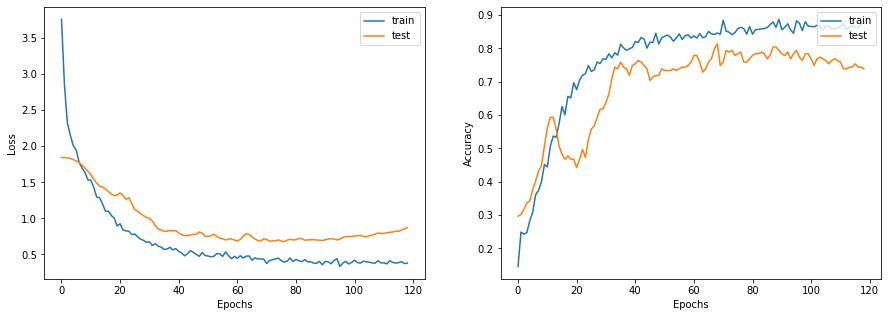

In [29]:
display_learning_curves(history)

test로 평가

In [30]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.34%


### Examine the baseline model predictions

Let's create new data instances by randomly generating binary word vectors with respect to the word presence probabilities.
- 단어가 존재하는 확률과 관련해서 이진 단어 벡터를 무작위로 만드는 새로운 데이터 인스턴스를 생성

In [32]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

- `tf.convert_to_tensor(logits)` logit을 텐서로 변환

In [33]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 5.14%
- Genetic_Algorithms: 2.01%
- Neural_Networks: 33.73%
- Probabilistic_Methods: 1.96%
- Reinforcement_Learning: 51.42%
- Rule_Learning: 1.73%
- Theory: 4.0%
Instance 2:
- Case_Based: 1.13%
- Genetic_Algorithms: 27.85%
- Neural_Networks: 63.9%
- Probabilistic_Methods: 2.06%
- Reinforcement_Learning: 4.68%
- Rule_Learning: 0.03%
- Theory: 0.35%
Instance 3:
- Case_Based: 8.41%
- Genetic_Algorithms: 1.72%
- Neural_Networks: 36.56%
- Probabilistic_Methods: 38.05%
- Reinforcement_Learning: 13.13%
- Rule_Learning: 0.29%
- Theory: 1.83%
Instance 4:
- Case_Based: 0.43%
- Genetic_Algorithms: 0.2%
- Neural_Networks: 1.88%
- Probabilistic_Methods: 94.5%
- Reinforcement_Learning: 0.11%
- Rule_Learning: 0.06%
- Theory: 2.82%
Instance 5:
- Case_Based: 1.46%
- Genetic_Algorithms: 2.31%
- Neural_Networks: 18.09%
- Probabilistic_Methods: 76.33%
- Reinforcement_Learning: 0.64%
- Rule_Learning: 0.17%
- Theory: 1.0%
Instance 6:
- Case_Based: 3.53%
- Genetic_Algorithms: 11.55%

### Build a Graph Neural Network Model

The graph data is represented by the graph_info tuple, which consists of the following three elements:

1. node_features: This is a [num_nodes, num_features] NumPy array that includes the node features. In this dataset, the nodes are the papers, and the node_features are the word-presence binary vectors of each paper.
    - 노드 특징을 포함하는 넘파이 배열이다.노드는 papers이고, node_features는 각 paper사이의 단어 존재 이진 벡터이다.(?)
2. edges: This is [num_edges, num_edges] NumPy array representing a sparse adjacency matrix of the links between the nodes. In this example, the links are the citations between the papers.
    - 노드 사이의 연결의 희소 인접 행렬을 나타내는 넘파이 배열이다. 이 예제ㅔ서 link는 paper 사이의 인용이다.
3. edge_weights (optional): This is a [num_edges] NumPy array that includes the edge weights, which quantify the relationships between nodes in the graph. In this example, there are no weights for the paper citations.
    - 그래프에서 노드 사이 관계를 정량화하는 엣지 가중치를 포함하는 넘파이 배열이다. 이 예제에서 논문 잉용에 대한 가중치는 없다.

In [34]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


### Implement a graph convolution layer

In [35]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [36]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [37]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.07379532  0.08565956 -0.00541672 -0.18548818 -0.01206006 -0.11272154
   0.017806  ]
 [ 0.02744446  0.01766552  0.03999214 -0.08814992 -0.02859545  0.11164439
   0.0324192 ]
 [-0.00644324 -0.02940626 -0.02032538  0.13659047  0.04400367 -0.01838759
  -0.05344848]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

In [38]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 3s 138ms/step - loss: 2.4008 - acc: 0.1511 - val_loss: 1.8998 - val_acc: 0.2965
Epoch 2/300
5/5 [==============================] - 0s 67ms/step - loss: 2.0232 - acc: 0.2276 - val_loss: 1.8785 - val_acc: 0.2965
Epoch 3/300
5/5 [==============================] - 0s 73ms/step - loss: 1.9302 - acc: 0.2809 - val_loss: 1.8739 - val_acc: 0.2965
Epoch 4/300
5/5 [==============================] - 0s 70ms/step - loss: 1.8926 - acc: 0.2969 - val_loss: 1.8749 - val_acc: 0.2965
Epoch 5/300
5/5 [==============================] - 0s 75ms/step - loss: 1.8514 - acc: 0.3067 - val_loss: 1.8746 - val_acc: 0.2965
Epoch 6/300
5/5 [==============================] - 0s 74ms/step - loss: 1.8606 - acc: 0.2773 - val_loss: 1.8703 - val_acc: 0.2965
Epoch 7/300
5/5 [==============================] - 0s 75ms/step - loss: 1.8297 - acc: 0.2942 - val_loss: 1.8652 - val_acc: 0.2965
Epoch 8/300
5/5 [==============================] - 0s 73ms/step - loss: 1.8390 - acc: 0.2

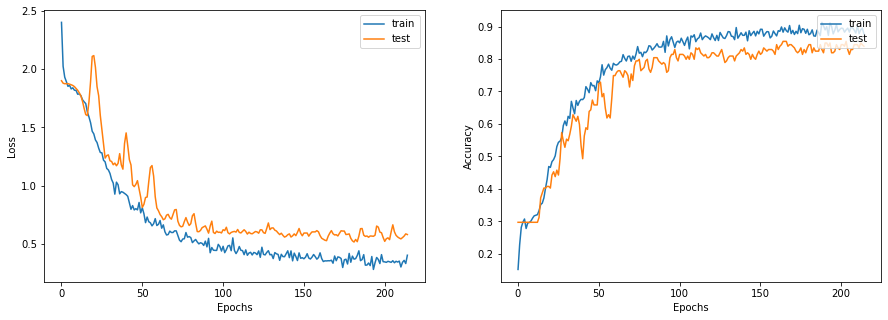

In [39]:
display_learning_curves(history)

In [40]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 80.92%


In [41]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)


In [42]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
Instance 1:
- Case_Based: 3.06%
- Genetic_Algorithms: 1.44%
- Neural_Networks: 5.4%
- Probabilistic_Methods: 0.2%
- Reinforcement_Learning: 89.31%
- Rule_Learning: 0.03%
- Theory: 0.55%
Instance 2:
- Case_Based: 0.1%
- Genetic_Algorithms: 99.61%
- Neural_Networks: 0.15%
- Probabilistic_Methods: 0.01%
- Reinforcement_Learning: 0.11%
- Rule_Learning: 0.02%
- Theory: 0.01%
Instance 3:
- Case_Based: 1.4%
- Genetic_Algorithms: 0.87%
- Neural_Networks: 27.22%
- Probabilistic_Methods: 65.77%
- Reinforcement_Learning: 1.6%
- Rule_Learning: 0.16%
- Theory: 2.98%
Instance 4:
- Case_Based: 0.02%
- Genetic_Algorithms: 0.07%
- Neural_Networks: 0.53%
- Probabilistic_Methods: 98.96%
- Reinforcement_Learning: 0.01%
- Rule_Learning: 0.0%
- Theory: 0.41%
Instance 5:
- Case_Based: 2.26%
- Genetic_Algorithms: 84.7%
- Neural_Networks: 5.29%
- Probabilistic_Methods: 1.4